# Sample scans

Notebook for testing algorithms for scanning

## Film Pigment

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import rawpy

In [4]:
film_image = "../test_images/sample-raw-scans/_DSF8434.RAF"

### Load film image & preprocess

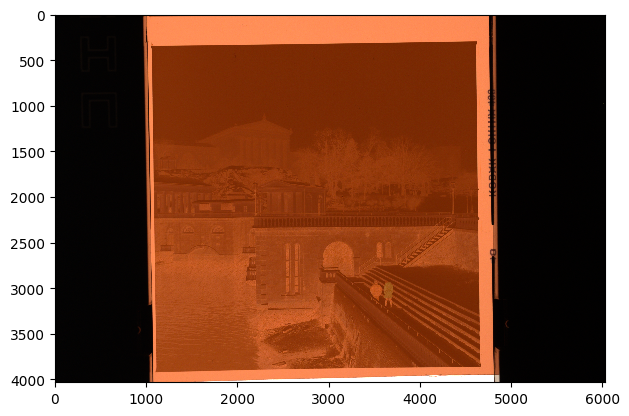

In [5]:
with rawpy.imread(film_image) as raw:
    image = raw.postprocess().copy()

image = ski.util.img_as_float64(image)
ski.io.imshow(image)

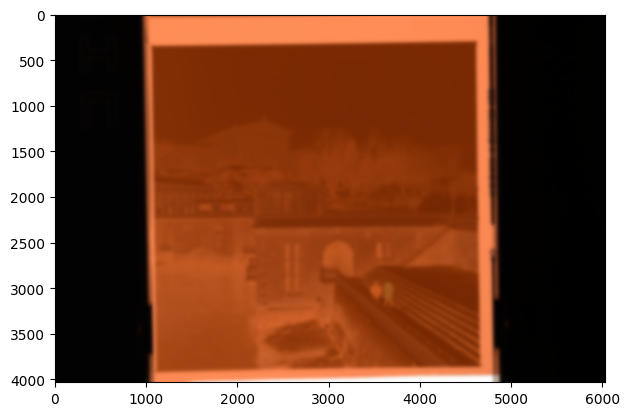

In [6]:
blurred = ski.filters.gaussian(image, sigma=(20, 20), channel_axis=-1)
ski.io.imshow(blurred)

### Obtain colour distribution

In [7]:
distribution, edges = np.histogramdd(blurred.reshape(-1, 3), bins=256, range=[(0,1), (0,1), (0, 1)],)

In [8]:
LIMIT_COLOURS = 50

sorted_count = np.sort(distribution, axis=None)[-LIMIT_COLOURS:]
indices = np.argsort(distribution, axis=None)[-LIMIT_COLOURS:]

sorted_colours = np.array(np.unravel_index(indices, shape=distribution.shape)).T
by_intensity = np.linalg.norm(sorted_colours, axis=1).argsort()

sorted_count_by_intensity = sorted_count[by_intensity]
sorted_colours_by_intensity = sorted_colours[by_intensity]

### Select `white` and `emulsion` colours

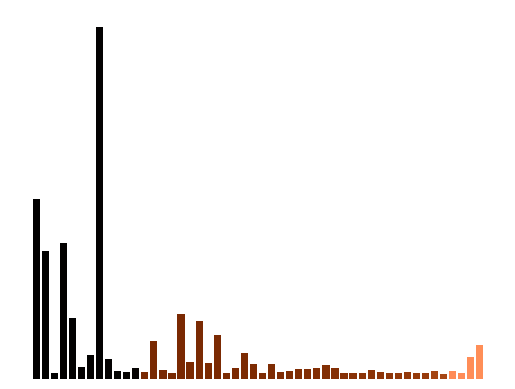

In [9]:
plt.bar(np.arange(LIMIT_COLOURS) + 1, sorted_count_by_intensity[-LIMIT_COLOURS:], color=sorted_colours_by_intensity[-LIMIT_COLOURS:] / 255)
plt.axis("off")
plt.show()

In [12]:
white = np.array([255, 255, 255])
emulsion = sorted_colours_by_intensity[-2]

print(f"White value: {tuple(white.tolist())}")
print(f"Emulsion value: {tuple(emulsion.tolist())}")

White value: (255, 255, 255)
Emulsion value: (255, 141, 87)


### Preprocess `emulsion` to get pigment

In [13]:
white_balanced_emulsion = (emulsion * 255 / white).astype(np.uint8)

# Set to maximum lightness
hsv = ski.color.rgb2hsv(np.array([[white_balanced_emulsion]]))
hsv[..., -1] = 1


pigment = (ski.color.hsv2rgb(hsv).squeeze() * 255).astype(np.uint8)

print(f"Pigment value: {tuple(pigment.tolist())}")


Pigment value: (255, 141, 87)


(np.float64(-0.5), np.float64(6031.5), np.float64(4031.5), np.float64(-0.5))

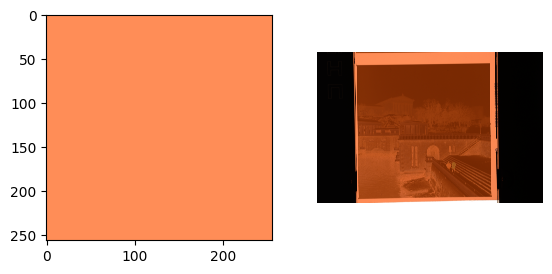

In [14]:
pigment_image = np.empty((256, 256, 3), dtype=np.uint8)
pigment_image[:, :] = pigment

figure, axes = plt.subplots(1, 2)
[pigment_axis, image_axis] = axes.ravel()

pigment_axis.imshow(pigment_image)
image_axis.imshow(image)

plt.axis("off")

## Layers

In [6]:
%reload_ext autoreload

In [7]:
%autoreload 2

In [1]:
from pathlib import Path
from nevernegative.layers.utils.resize import Resize
from nevernegative.scanner.simple import SimpleScanner
import matplotlib.pyplot as plt

In [2]:
images_folder = "/Users/louismanestar/Documents/Projects/Film Scanner/nevernegative/test_images/sample-raw-scans"
glob = "*.RAF"

### V1: Constrast Stretching

In [3]:
from nevernegative.layers.balancing.gamma import Gamma
from nevernegative.layers.balancing.contrast_stretch import ContrastStretch
from nevernegative.layers.utils.clip import Clip
from nevernegative.layers.balancing.invert import Invert
from nevernegative.layers.crop.box import BoxCrop

layers = [
    BoxCrop(),
    Invert(),
    ContrastStretch((0.01, 0.99), per_channel=True, mode="mean"),
    # Gamma(1.3, channel=2),
    Clip(),
]

['__abstractmethods__', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_image_to_axis', '_is_bw', '_plotting_config', 'figure_size', 'forward', 'plot', 'plot_path', 'plotting', 'plotting_name', 'setup']
False


### V1: Means Matching

In [5]:
from nevernegative.layers.balancing.gamma import Gamma
from nevernegative.layers.balancing.match_means import MatchMeans
from nevernegative.layers.balancing.shift import ShiftBound
from nevernegative.layers.balancing.invert import Invert
from nevernegative.layers.crop.box import BoxCrop

layers = [
    BoxCrop(),
    Invert(),
    MatchMeans(0, 1),
    MatchMeans(2, 1),
    ShiftBound(0.01, value=0.05),
    Gamma(0.9),
]

### V2: Removing Emulsion Pigment

In [3]:
from nevernegative.layers.balancing.brightness import Brightness
from nevernegative.layers.balancing.contrast import Contrast
from nevernegative.layers.balancing.pigment import RemoveEmulsionPigment
from nevernegative.layers.balancing.saturation import Saturation
from nevernegative.layers.balancing.temperature import Temperature
from nevernegative.layers.balancing.invert import Invert
from nevernegative.layers.crop.box import BoxCrop

layers = [
    BoxCrop(),
    # Temperature(temperature=5600),
    RemoveEmulsionPigment(pigment=(255, 141, 87)),
    Invert(),
    Brightness(0.7, channel=0),
    Brightness(0.6, channel=1),
    Brightness(0.49, channel=2),
    Brightness(0.2, mode="sum"),
    Contrast(4),
]

### Testing Layers

#### Single Image

In [4]:
scanner = SimpleScanner([Resize(height=400), *layers], device="mps")

filename = "_DSF8434.RAF"
output_path = Path("results/sample/")

processed = scanner.file(
    source=Path(images_folder) / filename,
    destination=Path("results/sample/"),
    is_raw=True,
    plot_path=output_path
)

plt.imshow(processed.permute(1, 2, 0).cpu().numpy())
plt.axis("off")

torch.Size([3, 400, 598]) torch.Size([261376, 2])
torch.Size([261376, 2, 2])
torch.Size([261376, 2])
tensor([  0, 329], device='mps:0')


/Users/louismanestar/Documents/Projects/Film Scanner/nevernegative/nevernegative/layers/crop/box.py:46: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  axis.scatter(*points.T.tolist(), color="green")


TypeError: bad operand type for unary -: 'list'

In [ ]:
scanner = SimpleScanner(layers, device="mps")

scanner.glob(
    source=(Path(images_folder) / glob).as_posix(),
    destination=Path("test_images/sample"),
    is_raw=True,
)

Proccesing images: 100%|██████████| 12/12 [03:36<00:00, 18.05s/it]


: 